# Adversarial Patch for Rotation-Based Class Confusion

## Creative Component
Involves training a single square patch to mislead a model into recognizing it as different classes depending on its orientation. This concept is tested in two distinct attempts:

#### Attempt 1: 
Train the patch to be recognized as four different classes based on its four possible orientations (0°, 90°, 180°, and 270°). This method aims to exploit the model’s reliance on orientation-specific features to misclassify the patch.

#### Attempt 2: 
To address the limitations observed in Attempt 1, where the top-1 attack accuracy averaged around 50% and top-5 attack accuracy averaged around 80%, tried simplifying the design by training the patch to be recognized as two different classes based on just two orientations (0° and 180°). This adjustment seeks to enhance the effectiveness of the adversarial patch by reducing potential confusion and improving its attack accuracy.

#### Trial and Error: How to choose the classes?
Theoretically, the most optimal results can be obtained when an object rotated by 90 degree looks like another object. For example, a horizontal banana when rotated by 90 degree may be trained to resemble a snake, which again rotated by 90 degree, may resemble a slug which when rotated again may be trained to be a goldfish. The selection of these classes is not perfect but a good baseline to start at.

## Practical Application
By using this patch to obscure or alter object detection systems, it can provide enhanced privacy protection by making objects appear differently depending on their angle. This can be particularly useful in environments where individuals seek to protect their identity or evade automated surveillance systems.

The goal is to assess the effectiveness of rotational adversarial patches in deceiving image classification models.

Reference: https://github.com/AIPI-590-XAI/Duke-AI-XAI

## Import Necessary and Packages

In [2]:
# Import Necessary and Packages
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.transforms import functional as F
import torchvision.models as models
from torchvision.datasets import ImageFolder
import torch.utils.data as data
import matplotlib.pyplot as plt
import numpy as np
import os
import json
from tqdm import tqdm

# Path to the folder where the datasets are to be downloaded
DATASET_PATH = "data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "saved_models"

import pytorch_lightning as pl

# Setting the seed
pl.seed_everything(1)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")

c:\Users\saksh\OneDrive\Documents\VSCode\XAI-Assignment1\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 1


## Download the TinyImageNet Dataset

In [3]:
# Download the TinyImageNet Dataset
import urllib.request
from urllib.error import HTTPError
import zipfile

# Github URL where the dataset is stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"

# Files to download
pretrained_files = [(DATASET_PATH, "TinyImageNet.zip")]

# Create checkpoint path if it doesn't exist yet
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)

    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")

        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

        if file_name.endswith(".zip"):
            print("Unzipping file...")
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(file_path.rsplit("/",1)[0])

## Load the pre-trained ResNet model with IMAGENET1K_V1 weights

In [4]:
# Load the pre-trained ResNet model with IMAGENET1K_V1 weights
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = models.resnet34(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)

# Sets the model to evaluation mode (no training).
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False  # Freezes the model's parameters so they won't be updated during training.

## Retrieve a subset of the original ImageNet Dataset

In [5]:
# Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])

# No resizing and center crop necessary as images are already preprocessed.
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)
])

# Load dataset and create data loader
imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
assert os.path.isdir(imagenet_path), f"Could not find the ImageNet dataset at expected path \"{imagenet_path}\". " + \
                                     f"Please make sure to have downloaded the ImageNet dataset here, or change the {DATASET_PATH=} variable."

dataset = ImageFolder(root=imagenet_path, transform=plain_transforms)
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)

# Load label names to interpret the label numbers 0 to 999
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)

def get_label_index(lab_str):
    assert lab_str in label_names, f"Label \"{lab_str}\" not found. Check the spelling of the class."
    return label_names.index(lab_str)

## Helper methods to Create and Place adversarial patch

In [6]:
# Create and Place adversarial patch
TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:,None,None], torch.FloatTensor(NORM_STD)[:,None,None]
def patch_forward(patch):
    # Map patch values from [-infty,infty] to ImageNet min and max
    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    return patch

def place_patch(img, patch):
    for i in range(img.shape[0]):
        h_offset = np.random.randint(0,img.shape[2]-patch.shape[1]-1)
        w_offset = np.random.randint(0,img.shape[3]-patch.shape[2]-1)
        img[i,:,h_offset:h_offset+patch.shape[1],w_offset:w_offset+patch.shape[2]] = patch_forward(patch)
    return img

def rotate_patch(patch, angle):
    """Rotate the patch by a specified angle."""
    return F.rotate(patch, angle)

def create_single_patch(patch_size=64):
    """Create a single adversarial patch."""
    return nn.Parameter(torch.zeros(3, patch_size, patch_size), requires_grad=True)

## Evaluate the effect of the adversarial patch

In [7]:
def eval_patch_per_rotation(model, patch, val_loader, target_class_mapping, angles):
    model.eval()
    results = {}
    
    with torch.no_grad():
        for angle in angles:
            tp, tp_5, counter = 0., 0., 0.
            rotated_patch = rotate_patch(patch, angle)

            for img, img_labels in tqdm(val_loader, desc=f"Validating {angle}°", leave=False):
                patch_img = place_patch(img, rotated_patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                
                target_class = target_class_mapping[angle]
                
                # Only count if the true label is not the target class
                mask = img_labels != target_class
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, mask).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), mask).sum()
                counter += mask.sum()

            acc = tp / counter
            top5 = tp_5 / counter
            results[angle] = {"acc": acc.item(), "top5": top5.item()}
    
    return results

## Train the patch

In [8]:
def patch_attack(model, patch_size=64, num_epochs=5, target_class_mapping=None, angles=None):
    """Train the adversarial patch with its rotated versions."""
    if target_class_mapping is None:
        raise ValueError("target_class_mapping must be provided")

    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=8)
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)

    # Initialize a single patch
    patch = create_single_patch(patch_size)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.9)
    loss_module = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, _ in t:
            # Create rotated versions of the patch
            rotated_patches = [rotate_patch(patch, angle) for angle in angles]

            # Accumulate losses for each rotated version
            total_loss = 0.0
            for angle, rotated_patch in zip(angles, rotated_patches):
                img_with_patch = place_patch(img, rotated_patch)
                img_with_patch = img_with_patch.to(device)
                target_labels = torch.full((img.shape[0],), target_class_mapping[angle], dtype=torch.long, device=device)
                pred = model(img_with_patch)
                
                loss = loss_module(pred, target_labels)
                total_loss += loss

            # Backpropagate only once per batch
            optimizer.zero_grad()
            total_loss.backward()  # Single backward pass
            optimizer.step()
            
            t.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss.item():.4f}")

    # Final validation
    results = eval_patch_per_rotation(model, patch, val_loader, target_class_mapping, angles)

    return patch, results

## Load existing or generate new evaluation results

In [15]:
def load_results(name):
    json_results_file = os.path.join(CHECKPOINT_PATH, f"{name}_patch_results.json")
    json_results = {}
    if os.path.isfile(json_results_file):
        with open(json_results_file, "r") as f:
            json_results = json.load(f)

    return json_results

In [16]:
# to save the results if new patches are trained
def save_results(patch_dict, name):
    result_dict = {cname: {psize: [t.item() if isinstance(t, torch.Tensor) else t
                                   for t in patch_dict[cname][psize]["results"]]
                           for psize in patch_dict[cname]}
                   for cname in patch_dict}
    with open(os.path.join(CHECKPOINT_PATH, f"{name}_patch_results.json"), "w") as f:
        json.dump(result_dict, f, indent=4)

In [17]:
def get_patches(patch_sizes, target_class_mapping, name, angles):
    result_dict = dict()

    result_dict[name] = dict()  # create empty dict for each class

    for patch_size in patch_sizes:
        file_name = os.path.join(CHECKPOINT_PATH, f"{name}_{patch_size}_patch.pt")

        # Load patch if pretrained file exists, otherwise start training
        if not os.path.isfile(file_name):
            patch, val_results = patch_attack(pretrained_model, patch_size=patch_size, num_epochs=5, target_class_mapping=target_class_mapping, angles=angles)
            print(f"Validation results for {name} and {patch_size}:", val_results)
            torch.save(patch, file_name)
        else:
            patch = torch.load(file_name)

        # Load evaluation results if exist, otherwise manually evaluate the patch
        json_results = load_results(name)
        if name in json_results:
            results = json_results[name][str(patch_size)]
        else:
            results = eval_patch_per_rotation(pretrained_model, patch, data_loader, target_class_mapping, angles)
        
        print(f"Validation results for {name} and {patch_size}:", results)

        # Store results and the patches in a dict for better access
        result_dict[name][patch_size] = {
            "results": results,
            "patch": patch
        }

    return result_dict

In [21]:
def validate_or_train(target_class_mapping, name, angles):
    patch_sizes = [64]
    # Retrieve or train patches with the specified mapping
    patch_dict = get_patches(patch_sizes, target_class_mapping, name, angles)

    save_results(patch_dict, name)

    return patch_dict

# Attempt 1

### Training with classes:
BATCH 1:
1. banana
2. sax
3. slug
4. goldfish

BATCH 2:
1. screwdriver
2. teapot
3. lipstick
4. mushroom


In [13]:
angles = [0, 90, 180, 270]

target_class_mapping_1_1 = {
    0: get_label_index('banana'),
    90: get_label_index('sax'),
    180: get_label_index('slug'),
    270: get_label_index('goldfish')
}

classes_1_1 = ['banana', "sax", "slug", "goldfish"]
name_1_1 = "test_1_1"

patch_dict_1_1 = validate_or_train(target_class_mapping_1_1, name_1_1, angles)

Validation results for test_1_1 and 64: {0: {'acc': 0.672690749168396, 'top5': 0.9477911591529846}, 90: {'acc': 0.38600000739097595, 'top5': 0.7559999823570251}, 180: {'acc': 0.5991984009742737, 'top5': 0.8957915902137756}, 270: {'acc': 0.6060000061988831, 'top5': 0.8820000290870667}}


Validation results for test_1_1 and 64: {0: {'acc': 0.6572572588920593, 'top5': 0.9309309124946594}, 90: {'acc': 0.3771771788597107, 'top5': 0.7443443536758423}, 180: {'acc': 0.5909910202026367, 'top5': 0.8872872591018677}, 270: {'acc': 0.6074073910713196, 'top5': 0.8948948979377747}}


#### The results from Attempt 1 Batch 1
1. For 0 degree - Class `banana`    : 67% Top 1 Attack Accuarcy  | 94% Top 5 Attack Accuracy
2. For 90 degree - Class `sax`      : 39% Top 1 Attack Accuarcy  | 76% Top 5 Attack Accuracy
3. For 180 degree - Class `slug`    : 60% Top 1 Attack Accuarcy  | 90% Top 5 Attack Accuracy
4. For 270 degree - Class `goldfish`: 61% Top 1 Attack Accuarcy  | 88% Top 5 Attack Accuracy

Average Top 1 Attack Accuarcy : 56.75% <br>
Average Top 5 Attack Accuracy : 87%

In [14]:
angles = [0, 90, 180, 270]

target_class_mapping_1_2 = {
    0: get_label_index('screwdriver'),
    90: get_label_index('teapot'),
    180: get_label_index('lipstick'),
    270: get_label_index('mushroom')
}

classes_1_2 = ['screwdriver', "teapot", "lipstick", "mushroom"]
name_1_2 = "test_1_2"

patch_dict_1_2 = validate_or_train(target_class_mapping_1_2, name_1_2, angles)

Validation results for test_1_2 and 64: {0: {'acc': 0.0860000029206276, 'top5': 0.36000001430511475}, 90: {'acc': 0.4048096239566803, 'top5': 0.7314629554748535}, 180: {'acc': 0.052000001072883606, 'top5': 0.20200000703334808}, 270: {'acc': 0.1720000058412552, 'top5': 0.5519999861717224}}


Validation results for test_1_2 and 64: {0: {'acc': 0.0862862840294838, 'top5': 0.3895895779132843}, 90: {'acc': 0.37597596645355225, 'top5': 0.6952952742576599}, 180: {'acc': 0.047047048807144165, 'top5': 0.16716717183589935}, 270: {'acc': 0.18058058619499207, 'top5': 0.5399399399757385}}


#### The results from Attempt 1 Batch 2
1. For 0 degree - Class `screwdriver`: 8.6% Top 1 Attack Accuarcy  | 36% Top 5 Attack Accuracy
2. For 90 degree - Class `teapot`    : 40% Top 1 Attack Accuarcy   | 73% Top 5 Attack Accuracy
3. For 180 degree - Class `lipstick` : 5.2% Top 1 Attack Accuarcy  | 20% Top 5 Attack Accuracy
4. For 270 degree - Class `mushroom` : 17% Top 1 Attack Accuarcy   | 55% Top 5 Attack Accuracy

Average Top 1 Attack Accuarcy : 17.7% <br>
Average Top 5 Attack Accuracy : 46%

We can conclude that Attempt 1 Batch 2 results are very poor and the selection of classes for rotation based class confusion is very important.

# Attempt 2

### Training with classes:
BATCH 1:
1. banana
2. school bus

BATCH 2:
1. red wine
2. lipstick


In [22]:
angles = [0, 180]
target_class_mapping_2_1 = {
    0: get_label_index('banana'),
    180: get_label_index('school bus')
}

classes_2_1 = ['banana', "school bus"]
name_2_1 = "test_2_1"

patch_dict_2_1 = validate_or_train(target_class_mapping_2_1, name_2_1, angles)

Validation results for test_2_1 and 64: {0: {'acc': 0.7109109163284302, 'top5': 0.9445445537567139}, 180: {'acc': 0.7305305600166321, 'top5': 0.9379379153251648}}


#### The results from Attempt 2 Batch 1
1. For 0 degree - Class `banana`: 71% Top 1 Attack Accuarcy  | 94% Top 5 Attack Accuracy
2. For 180 degree - Class `school bus` : 73% Top 1 Attack Accuarcy  | 93% Top 5 Attack Accuracy

Average Top 1 Attack Accuarcy : 72% <br>
Average Top 5 Attack Accuracy : 93.5%

In [23]:
angles = [0, 180]
target_class_mapping_2_2 = {
    0: get_label_index('red wine'),
    180: get_label_index('lipstick')
}

classes_2_2 = ['red wine', "lipstick"]
name_2_2 = "test_2_2"

patch_dict_2_2 = validate_or_train(target_class_mapping_2_2, name_2_2, angles)

Validation results for test_2_2 and 64: {0: {'acc': 0.7739999890327454, 'top5': 0.9700000286102295}, 180: {'acc': 0.7120000123977661, 'top5': 0.9559999704360962}}


Validation results for test_2_2 and 64: {0: {'acc': 0.7833833694458008, 'top5': 0.9751752018928528}, 180: {'acc': 0.7221221327781677, 'top5': 0.9475475549697876}}


#### The results from Attempt 2 Batch 2
1. For 0 degree - Class `red wine`: 77% Top 1 Attack Accuarcy  | 97% Top 5 Attack Accuracy
2. For 180 degree - Class `lipstick` : 71% Top 1 Attack Accuarcy  | 95% Top 5 Attack Accuracy

Average Top 1 Attack Accuarcy : 74% <br>
Average Top 5 Attack Accuracy : 96%

## Visualize patches
### Best Batches from both attempts i.e. Attempt 1 Batch 1 and Attempt 2 Batch 2

PATCH FOR BEST ATTEMPT 1 RESULTS


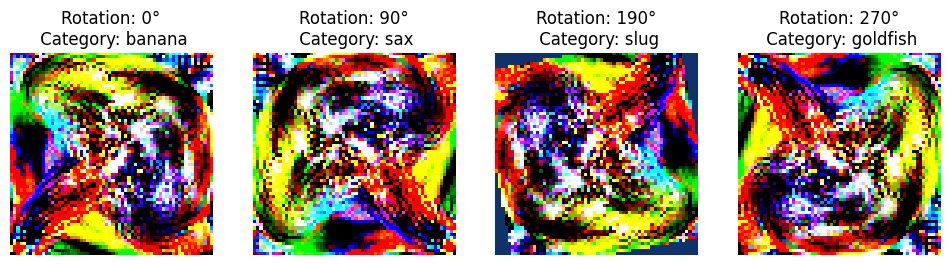

PATCH FOR BEST ATTEMPT 2 RESULTS


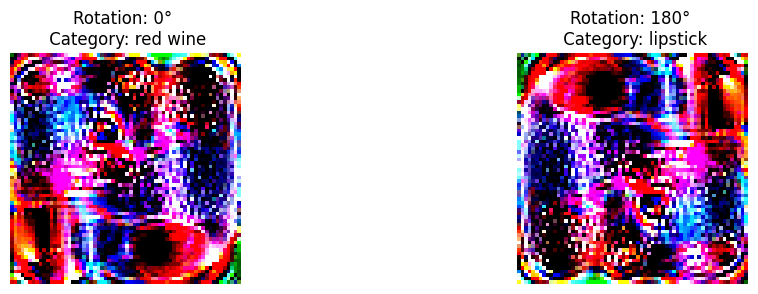

In [33]:
def visualize_patch_attempt_1(patch, classes, angles):
    fig, ax = plt.subplots(1, len(angles), figsize=(12, 3))
    for i, (angle, cat) in enumerate(zip(angles, classes)):
        rotated_patch = rotate_patch(patch, angle)
        rotated_patch = patch_forward(rotated_patch)  # Normalize patch for display

        # Convert tensor to numpy array for plotting
        patch_img = rotated_patch.permute(1, 2, 0).cpu().detach().numpy()
        patch_img = np.clip(patch_img, 0, 1)  # Ensure valid image range [0, 1]

        ax[i].imshow(patch_img)
        ax[i].axis('off')
        ax[i].set_title(f'Rotation: {angle}°\n Category: {cat}')

    plt.show()

# Example usage
angles = [0, 90, 190, 270]
print("PATCH FOR BEST ATTEMPT 1 RESULTS")
visualize_patch_attempt_1(patch_dict_1_1[name_1_1][64]['patch'], classes_1_1, angles)

def visualize_patch_attempt_2(patch, classes, angles):
    fig, ax = plt.subplots(1, len(angles), figsize=(12, 3))
    for i, (angle, cat) in enumerate(zip(angles, classes)):
        rotated_patch = rotate_patch(patch, angle)
        rotated_patch = patch_forward(rotated_patch)  # Normalize patch for display

        # Convert tensor to numpy array for plotting
        patch_img = rotated_patch.permute(1, 2, 0).cpu().detach().numpy()
        patch_img = np.clip(patch_img, 0, 1)  # Ensure valid image range [0, 1]

        ax[i].imshow(patch_img)
        ax[i].axis('off')
        ax[i].set_title(f'Rotation: {angle}° \n Category: {cat}')
        ax[i].set_xlabel(cat)  # Set the category as xlabel

    plt.show()

angles = [0, 180]
print("PATCH FOR BEST ATTEMPT 2 RESULTS")
visualize_patch_attempt_2(patch_dict_2_2[name_2_2][64]['patch'], classes_2_2, angles)


# See Attack Predictions on original dataset

In [42]:
def show_prediction(img, label, pred, K=5, adv_img=None, noise=None, target=None):

    if isinstance(img, torch.Tensor):
        # Detach tensor and convert to numpy
        img = img.detach().cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()

    # Plot on the left the image with the true label as title.
    # On the right, have a horizontal bar plot with the top k predictions including probabilities
    if noise is None or adv_img is None:
        fig, ax = plt.subplots(1, 2, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 5, figsize=(12,2), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})

    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis('off')

    if adv_img is not None and noise is not None:
        # Visualize adversarial images
        adv_img = adv_img.detach().cpu().permute(1, 2, 0).numpy()
        adv_img = (adv_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        adv_img = np.clip(adv_img, a_min=0.0, a_max=1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title('Adversarial')
        ax[1].axis('off')
        # Visualize noise
        noise = noise.detach().cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.5 # Scale between 0 to 1
        ax[2].imshow(noise)
        ax[2].set_title('Noise')
        ax[2].axis('off')
        # buffer
        ax[3].axis('off')

    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title(f'Predictions: Target - {target}')

    plt.show()
    plt.close()


In [43]:
def get_nth_batch(data_loader, n):
    for idx, (data_batch, label_batch) in enumerate(data_loader):
        if idx == n:
            return data_batch, label_batch
    raise IndexError(f"Batch {n} is out of range")

# Get the 10th batch
exmp_batch, label_batch = get_nth_batch(data_loader, 11)  # Batch indices start at 0

def perform_patch_attack(patch, classes, angles):
    for angle, target in zip(angles, classes):
        # Clone the original batch for each rotation
        patch_batch = exmp_batch.clone()
        
        # Rotate and place the patch
        rotated_patch = rotate_patch(patch, angle)
        patch_batch = place_patch(patch_batch, rotated_patch)
        
        # Get predictions
        with torch.no_grad():
            patch_preds = pretrained_model(patch_batch.to(device))
        
        print(f"Results for {angle}° rotated patch:")
        for i in range(1, 17, 5):
            show_prediction(patch_batch[i], label_batch[i], patch_preds[i], K=5, adv_img=None, noise=None, target=target)



RESULTS FOR ATTEMPT 2 BATCH
Results for 0° rotated patch:


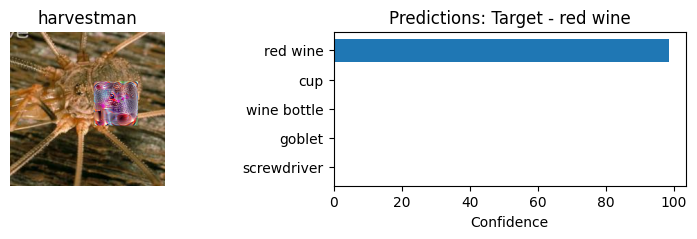

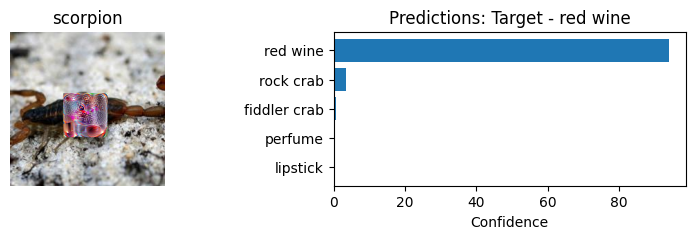

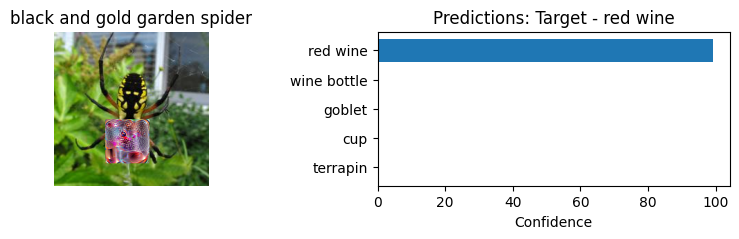

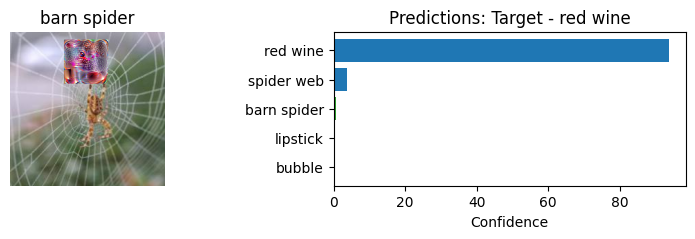

Results for 180° rotated patch:


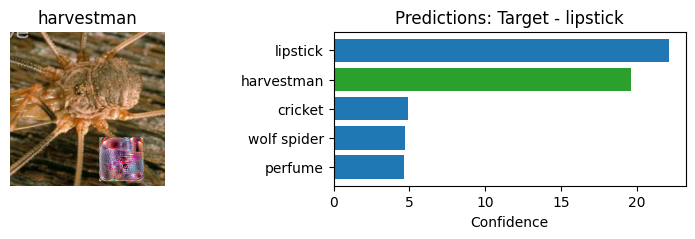

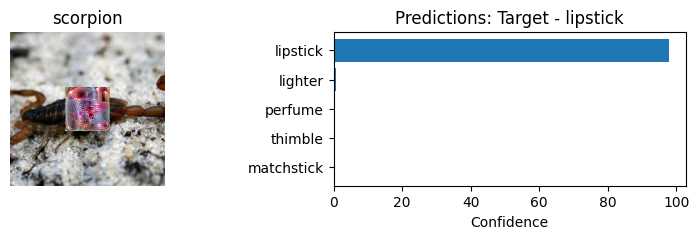

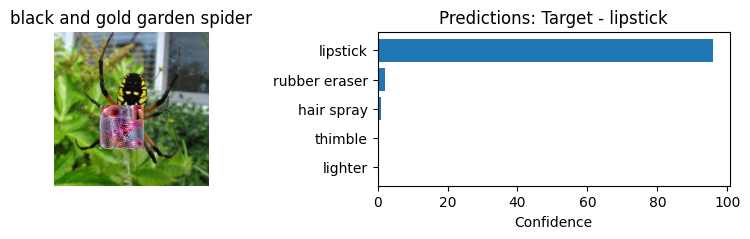

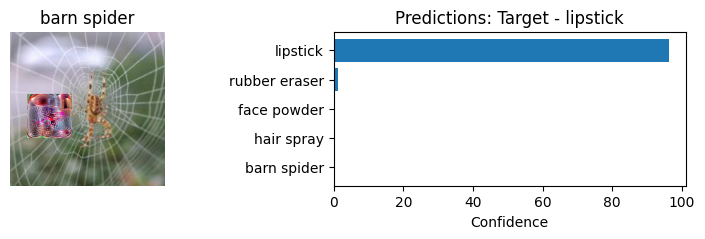

In [45]:
print("RESULTS FOR ATTEMPT 2 BATCH")
perform_patch_attack(patch_dict_2_2[name_2_2][64]['patch'], classes_2_2, angles=[0, 180])

The same patch when rotated by 180 degree fools all images into believing two different classes

RESULTS FOR ATTEMPT 1 BATCH
Results for 0° rotated patch:


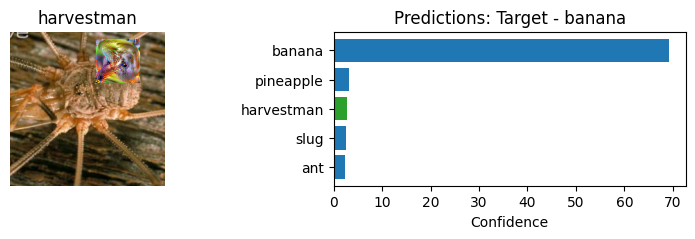

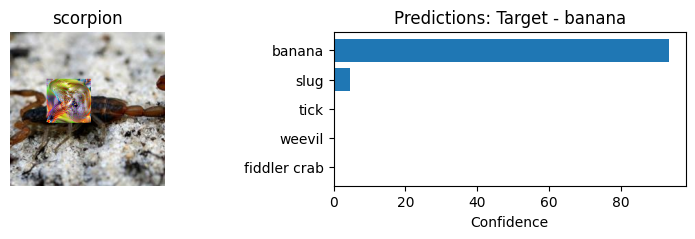

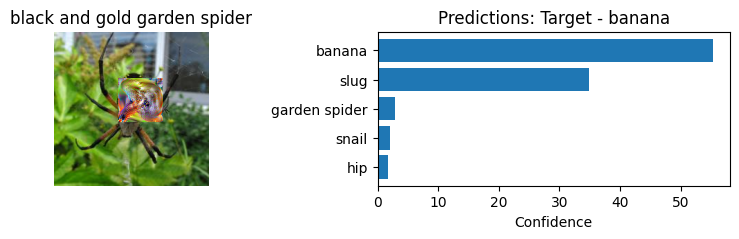

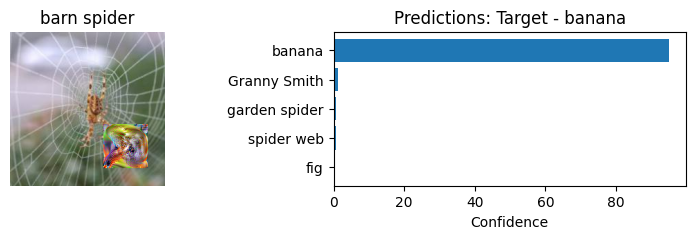

Results for 90° rotated patch:


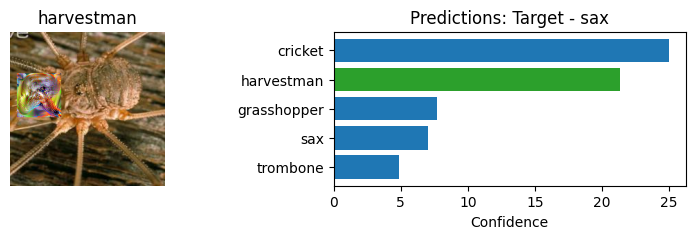

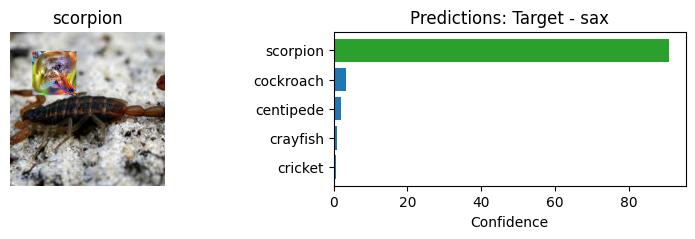

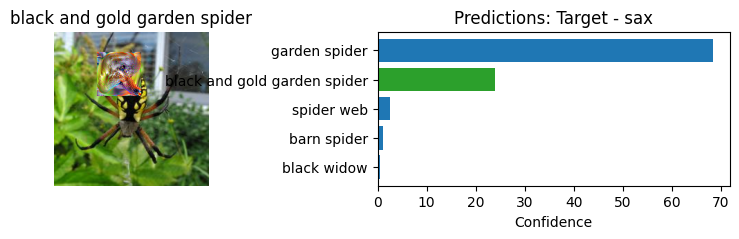

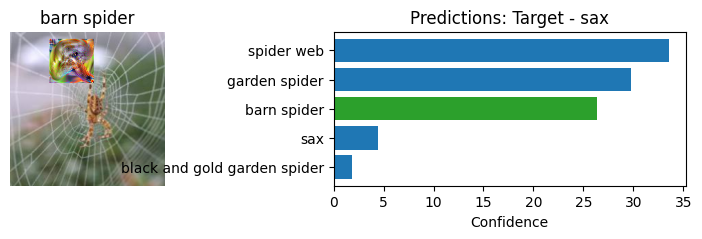

Results for 180° rotated patch:


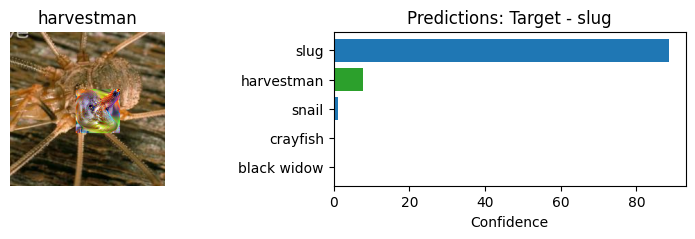

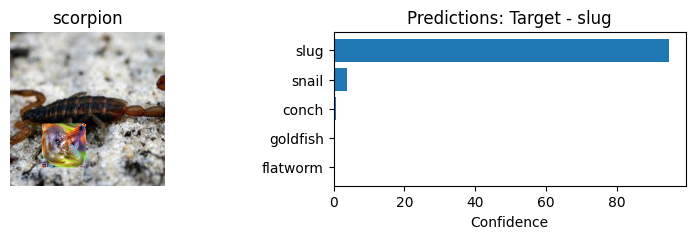

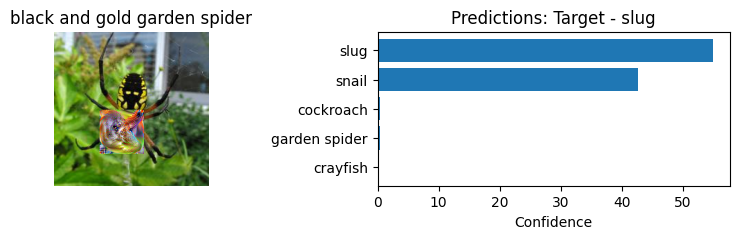

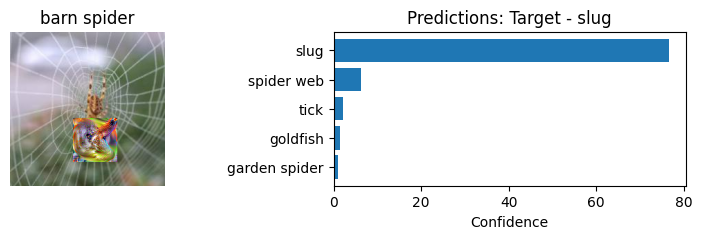

Results for 270° rotated patch:


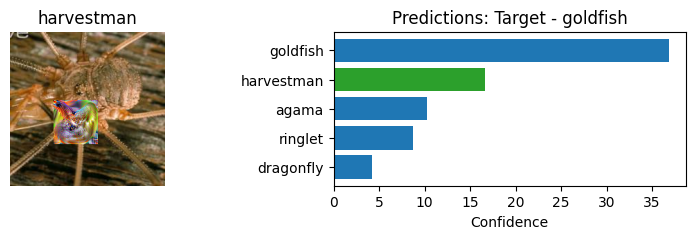

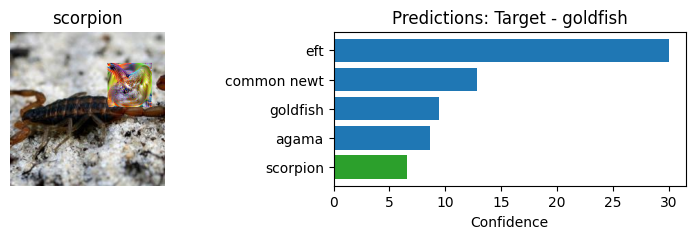

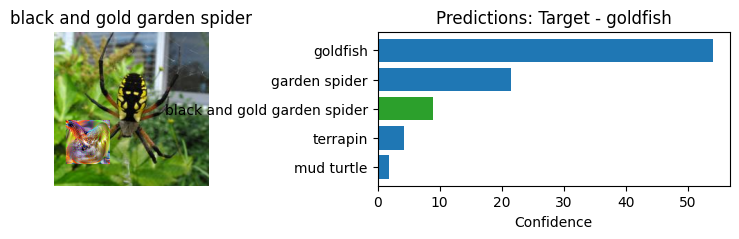

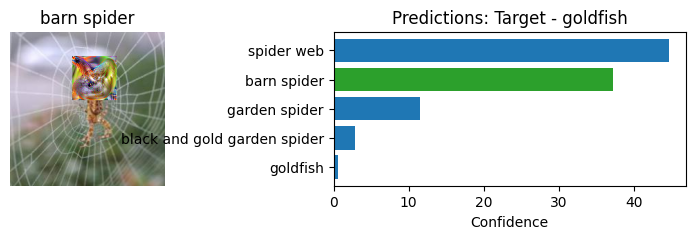

In [46]:
print("RESULTS FOR ATTEMPT 1 BATCH")
perform_patch_attack(patch_dict_1_1[name_1_1][64]['patch'], classes_1_1, angles=[0, 90, 180, 270])

Apart from the class "Sax", the model performs decently with 80% top 5 attack accuracy